In [1]:
import json
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np

from urllib.request import urlopen, HTTPError

In [2]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from wordcloud import WordCloud, STOPWORDS

In [4]:
def make_wordcloud(df, column_name):
    
    text = ' '.join(df[column_name].values)
    
    exclude = [
        'using',
        'CMS',
        'open',
        'data',
        'collider',
        'event',
        'TeV',
        'analysis',
        'based',
        'LHC',
        'particle',
        'end'
    ]

    stopwords = set(STOPWORDS)

    for e in exclude:
        stopwords.add(e)
    
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=600,
        height=400
    ).generate(text)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [5]:
def handle_doi_queries(dois):
    
    doi_url = 'https://doi.org/api/handles/'
    recids = []
        
    for doi in dois:
        '''
        Some of the DOIs referenced are invalid, either having an extra ":" 
        appended to the end or having the year in parentheses appended.
        In the former case they are dupicates and we can skip.
        In the latter clean them up.
        '''
        
        if ':' in doi:
            continue
        if '(' in doi:
            doi = doi[:-6]
            
        try:
            response = json.load(
                urlopen(f'{doi_url}{doi}')
            )
        
            url = response['values'][1]['data']['value']
            recid = url.split('/')[-1]
        
            recids.append(recid)
         
        except HTTPError:
            print('Error '+doi)
        
    return recids
    
def resolve_dois(df):
    '''
    The references that come from the Inspire API results
    often have useful information on the datasets in "misc"
    and often has the CODP records as well. In several cases
    they do not. Since we have the DOIs use the DOI API
    
    https://www.doi.org/the-identifier/resources/factsheets/doi-resolution-documentation
    
    and resolve the CODP record URL and add it to the dataframe.
    
    We can get the information from the DOI using the CODP CLI as well
    (and this probably better).
    '''
    df['codp_recids'] = df['dois_referenced'].map(
        lambda x: handle_doi_queries(x)
    )

In [6]:
def process_dataframe(input_json):
    
    exclude_names = [
        'McCauley',
        'Bellis',
        'Lange',
        'Tibor',
        'Šimko',
        'Carerra',
        'Geiser',
        'Lassila-Perini',
        'Dallmeier-Tiessen',
        'Calderon',
        'Rao',
        'Socher',
        'Carrera',
        'Herterich'
    ]
    
    df = pd.read_json(input_json)
    
    '''
    Adds a new column where each row is a list of names from exclude_names 
    that match (substring) those in the author list contained in the authors column
    '''
    df['exclude'] = df['authors'].map(lambda x: [e for e in exclude_names if any(e in xn for xn in x)])
    
    print(df.shape[0])
    
    '''
    Filter out rows in-place where there are matches from the
    excluded names
    '''
    df = df[df['exclude'].str.len() == 0]
    
    print(df.shape[0])
    
    '''
    Reorder the rows by date and reorder the indices. 
    Then add an index column.
    '''
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop='True', inplace=True)
    df.reset_index(inplace=True)
    
    '''
    Format date
    '''
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    return df

In [7]:
def make_histogram(df, date_range, nbins, title):
    
    dates = df['date'].to_numpy(dtype='datetime64[Y]')
    
    h, b = np.histogram(
        dates.astype(int),
        range=date_range,
        bins=nbins
    )

    b = np.array([np.datetime64(int(value), 'Y') for value in b])

    plt.bar(b[:-1], h, width=np.diff(b), ec='black', align='edge')
    plt.gca().set_xticks(b)
    plt.gca().set_xticklabels(b, rotation=45)

    plt.title(title)


    plt.show()

In [8]:
data_releases = [
    '2014-11-20',
    '2016-04-22',
    '2017-12-20',
    '2019-07-18',
    '2020-08-27',
    '2020-12-21',
    '2021-12-20',
    '2022-12-05',
    '2023-09-18',
    '2024-04-02'
]

These papers reference a CMS open data DOI

In [9]:
idf = process_dataframe('data/inspire.json')

81
66


In [10]:
resolve_dois(idf)

Error 10.7483/OPENDATA.CMS.7347
Error 10.7483/OPENDATA.CMS.29BN


In [11]:
idf.head()

,index,abstract,authors,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
0,0,The splitting function is a universal property...,"[Larkoski, Andrew, Marzani, Simone, Thaler, Je...",2017-04-19,article,10.1103/PhysRevLett.119.132003,"[10.7483/OPENDATA.CMS.3S7F.2E9W, 10.7483/OPEND...","[jet: energy, energy: high, singularity: colli...",Phys.Rev.Lett.,Exposing the QCD Splitting Function with CMS O...,https://inspirehep.net/literature/1591972,[],"[5, 21]"
1,1,The application of deep learning techniques us...,"[Madrazo, Celia Fernández, Cacha, Ignacio Here...",2017-08-25,conference paper,10.1051/epjconf/201921406017,"[10.7483/opendata.cms.txt4.4rrp, 10.7483/opend...","[Deep Learning, Machine Learning, Convolutiona...",EPJ Web Conf.,Application of a Convolutional Neural Network ...,https://inspirehep.net/literature/1618344,[],"[1395, 1633, 1544]"
2,2,Daily operation of a large-scale experiment is...,"[Borisyak, Maxim, Ratnikov, Fedor, Derkach, De...",2017-09-26,conference paper,10.1088/1742-6596/898/9/092041,"[10.7483/OPENDATA.CMS.6BPY.XFRQ:, 10.7483/OPEN...","[data acquisition, quality: monitoring, CMS, C...",J.Phys.Conf.Ser.,Towards automation of data quality system for ...,https://inspirehep.net/literature/1625297,[],"[8, 14, 12]"
3,3,The need for processing the ever-increasing am...,"[Piparo, D., Tejedor, E., Guiraud, E., Ganis, ...",2017-11-27,conference paper,10.1088/1742-6596/898/7/072022,[10.7483/OPENDATA.CMS.JCDC.9CUH],[],J.Phys.Conf.Ser.,Expressing Parallelism with ROOT,https://inspirehep.net/literature/1638554,[],[1640]
4,4,Deep generative models parametrised by neural ...,"[Musella, Pasquale, Pandolfi, Francesco]",2018-05-03,article,10.1007/s41781-018-0015-y,"[10.7483/OPENDATA.CMS.Q3BX.69VQ, 10.7483/OPEND...","[Generative adversarial networks, Deep learnin...",Comput.Softw.Big Sci.,Fast and Accurate Simulation of Particle Detec...,https://inspirehep.net/literature/1671151,[],"[1539, 1555, 1562, 1348, 1369, 1469, 1553, 155..."


In [12]:
idf.tail()

,index,abstract,authors,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
61,61,Despite extensive theoretical and experimental...,"[Cesarotti, Cari]",2023-12-05,thesis,,"[10.7483/OPENDATA.CMS.7347.JDWH, 10.7483/OPEND...","[collider, dark matter, future collider, hidde...",,Hints of a Hidden World,https://inspirehep.net/literature/2730282,[],"[414, 17, 1395, 1393, 1389, 1390, 1391, 1392, ..."
62,62,We use the CMS Open Data to examine the perfor...,"[Dolan, Matthew J., Gargalionis, John, Ore, Ay...",2023-12-07,article,,"[10.7483/OPENDATA.CMS.UP77.P6PQ, 10.7483/OPEND...","[gluon: jet, fluctuation: statistical, perform...",,Quark-versus-gluon tagging in CMS Open Data wi...,https://inspirehep.net/literature/2731403,[],"[21, 1366, 1539, 1555, 1562, 1348, 1369, 1469,..."
63,63,Après l'observation du boson de Higgs par les ...,"[Lohezic, Victor]",2024-01-16,thesis,,[10.7483/OPENDATA.CMS.2W51.W8AT],"[LHC, CMS upgrade, Higgs, Timing, Deep learnin...",,The measurement of the Higgs Boson properties ...,https://inspirehep.net/literature/2747079,[],[7778]
64,64,This study presents a novel method for the def...,"[Sunneborn Gudnadottir, Olga, Gallén, Axel, Ri...",2024-04-08,article,,"[10.7483/OPENDATA.CMS.29BN, 10.7483/OPENDATA.C...","[CERN LHC Coll: upgrade, new physics: search f...",,Sparks in the Dark,https://inspirehep.net/literature/2774596,[],[24119]
65,65,"In the realm of scientific computing, both Jul...","[Osborne, Ianna, Pivarski, Jim, Ling, Jerry]",2024-04-30,conference paper,,[10.7483/OPENDATA.CMS.LVG5.QT81],[],,Bridging Worlds: Achieving Language Interopera...,https://inspirehep.net/literature/2781858,[],[12341]


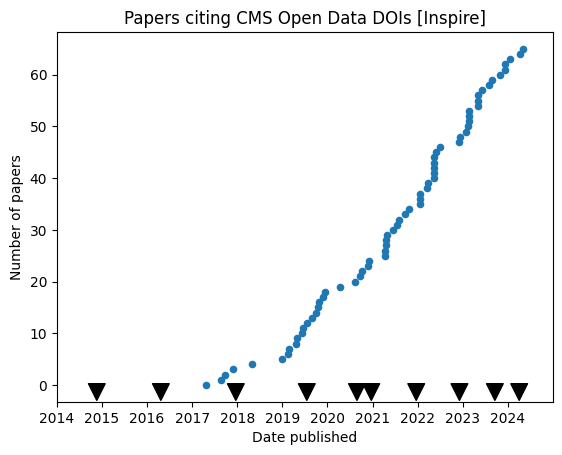

In [13]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2024, 12, 31)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -3), 
            xytext=(date, -2),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )


ax = idf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title='Papers citing CMS Open Data DOIs [Inspire]'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

add_release_dates(ax)

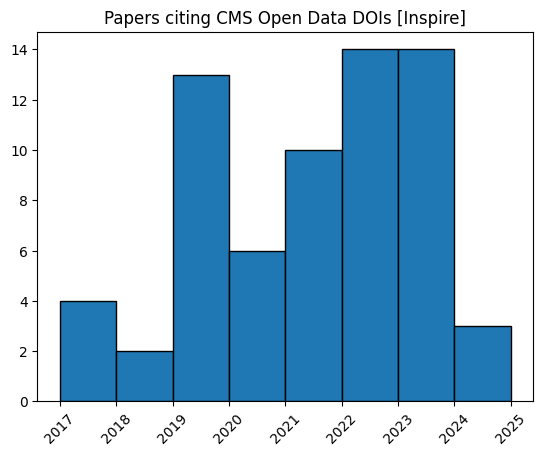

In [14]:
make_histogram(
    idf,
    (np.datetime64('2017').astype(int), np.datetime64('2025').astype(int)),
    8,
    'Papers citing CMS Open Data DOIs [Inspire]'
)

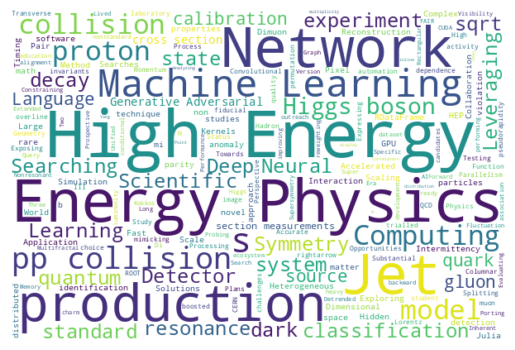

In [15]:
make_wordcloud(idf, 'title')

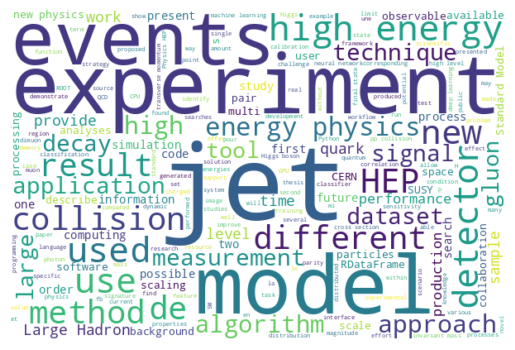

In [16]:
make_wordcloud(idf, 'abstract')

In [17]:
%pip install cernopendata-client

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
def get_codp_title(recid):
    
    results = subprocess.run([
        'cernopendata-client',
        'get-metadata',
        '--recid',
        recid,
        '--output-value',
        'title'],
        stdout=subprocess.PIPE
    )
    
    return results.stdout.decode('utf-8')
    

titles = idf['codp_recids'].map(lambda x: [get_codp_title(str(rid)) for rid in x])

In [29]:
print(titles)

0     [/Jet/Run2010B-Apr21ReReco-v1/AOD\n, /Jet/Run2...
1     [/DYJetsToLL_TuneZ2_M-50_7TeV-madgraph-tauola/...
2     [/MinimumBias/Run2010B-Apr21ReReco-v1/AOD\n, /...
3     [/WZJetsTo3LNu_TuneZ2_7TeV-madgraph-tauola/Sum...
4     [/QCD_Pt-30to50_TuneZ2_7TeV_pythia6/Summer11Le...
                            ...                        
61    [2018 CMS data preservation, re-use and open a...
62    [/Jet/Run2011A-12Oct2013-v1/AOD\n, /QCD_Pt-15t...
63    [/GJet_Pt40_doubleEMEnriched_TuneZ2star_8TeV_e...
64        [/SingleMuon/Run2015D-16Dec2015-v1/MINIAOD\n]
65    [DoubleMuParked dataset from 2012 in NanoAOD f...
Name: codp_recids, Length: 66, dtype: object


In [30]:
adf = process_dataframe('data/arxiv.json')

29
28


In [31]:
adf.head()

,index,abstract,authors,date,doi,title,url,exclude
0,0,The splitting function is a universal property...,"[Andrew Larkoski, Simone Marzani, Jesse Thaler...",2017-04-17,http://dx.doi.org/10.1103/PhysRevLett.119.132003,Exposing the QCD Splitting Function with CMS O...,http://arxiv.org/abs/1704.05066v3,[]
1,1,We use public data from the CMS experiment to ...,"[Aashish Tripathee, Wei Xue, Andrew Larkoski, ...",2017-04-19,http://dx.doi.org/10.1103/PhysRevD.96.074003,Jet Substructure Studies with CMS Open Data,http://arxiv.org/abs/1704.05842v3,[]
2,2,This paper describes the construction of novel...,"[Michael Andrews, Manfred Paulini, Sergei Gley...",2018-07-31,http://dx.doi.org/10.1007/s41781-020-00038-8,End-to-End Physics Event Classification with C...,http://arxiv.org/abs/1807.11916v3,[]
3,3,We study dimuon events in 2.11/fb of 7 TeV pp ...,"[Cari Cesarotti, Yotam Soreq, Matthew J. Stras...",2019-02-12,http://dx.doi.org/10.1103/PhysRevD.100.015021,Searching in CMS Open Data for Dimuon Resonanc...,http://arxiv.org/abs/1902.04222v2,[]
4,4,We describe the construction of end-to-end jet...,"[Michael Andrews, John Alison, Sitong An, Patr...",2019-02-21,http://dx.doi.org/10.1016/j.nima.2020.164304,End-to-End Jet Classification of Quarks and Gl...,http://arxiv.org/abs/1902.08276v2,[]


In [32]:
adf.tail()

,index,abstract,authors,date,doi,title,url,exclude
23,23,Precise measurements of the energy of jets eme...,"[Daniel Holmberg, Dejan Golubovic, Henning Kir...",2023-08-24,http://dx.doi.org/10.1007/s41781-023-00103-y,Jet energy calibration with deep learning as a...,http://arxiv.org/abs/2308.12724v2,[]
24,24,We use the CMS Open Data to examine the perfor...,"[Matthew J. Dolan, John Gargalionis, Ayodele Ore]",2023-12-06,http://arxiv.org/abs/2312.03434v1,Quark-versus-gluon tagging in CMS Open Data wi...,http://arxiv.org/abs/2312.03434v1,[]
25,25,This study aims to improve the performance of ...,"[Tomoe Kishimoto, Masahiro Morinaga, Masahiko ...",2023-12-12,http://arxiv.org/abs/2312.06909v1,Pre-training strategy using real particle coll...,http://arxiv.org/abs/2312.06909v1,[]
26,26,This note summarizes the lectures given in the...,[Konstantinos Theofilatos],2024-03-13,http://arxiv.org/abs/2403.08907v1,The terascale tutorial,http://arxiv.org/abs/2403.08907v1,[]
27,27,This study presents a novel method for the def...,"[Olga Sunneborn Gudnadottir, Axel Gallén, Giul...",2024-04-05,http://arxiv.org/abs/2404.04138v1,Sparks in the Dark,http://arxiv.org/abs/2404.04138v1,[]


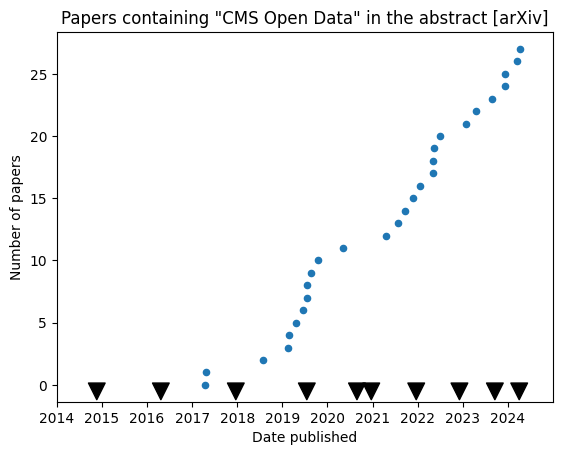

In [33]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2024, 12, 31)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -1.2), 
            xytext=(date, 0),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )

ax = adf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title='Papers containing "CMS Open Data" in the abstract [arXiv]'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

add_release_dates(ax)

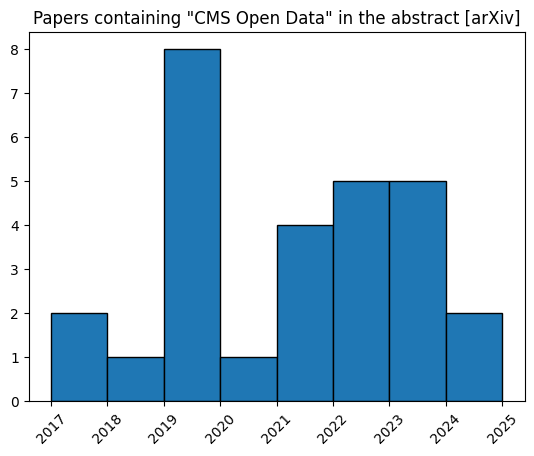

In [34]:
make_histogram(
    adf,
    (np.datetime64('2017').astype(int), np.datetime64('2025').astype(int)),
    8,
    'Papers containing "CMS Open Data" in the abstract [arXiv]'
)

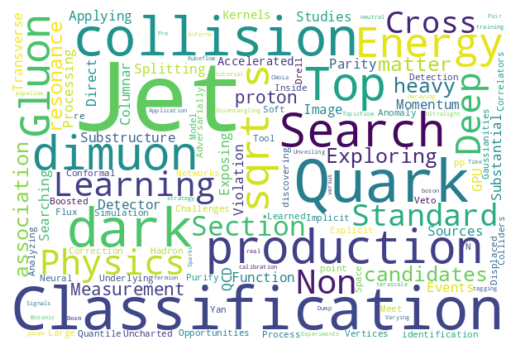

In [35]:
make_wordcloud(adf, 'title')

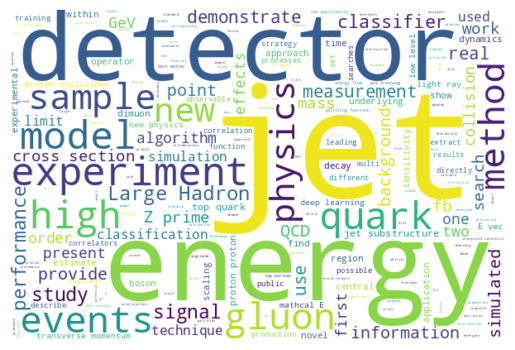

In [36]:
make_wordcloud(adf, 'abstract')